# RASPlant

> Objetivo: Desenvolver uma rede neural capaz de identificar plantas alimentícias não convencionais (PANCs)



# Bibliotecas necessárias

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
import numpy as np
import random
import shutil
from shutil import copyfile
import os
import cv2
from glob import glob
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Preparação do Dataset

> O bloco abaixo irá realizar a randomização e separação do dataset em duas pastas (Training e Testing) com uma determinada proporção especificada no código.



In [ ]:
#Definiu-se algumas variáveis importantes para blocos futuros
class_qtd=[]
num_class=0

#Função responsável por criar todas as pastas do dataset no drive
def cria_diretorio(path):
  if not os.path.exists(path):
      os.mkdir(path)
      print("Diretório "+path+" criado com sucesso")
  else:
      print("Diretório "+path+" já foi criado")

#Esta função realiza, além da verificação da integridade de cada imagem, a randomização e separação do dataset em duas pastas 
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    content=os.listdir(SOURCE)
    content=random.sample(content,len(content))
    class_qtd.append(len(content))
    for n,fname in enumerate(content):
        if(n<(SPLIT_SIZE*len(content)) and os.path.getsize(f"{SOURCE}/{fname}")!=0):
            copyfile(f"{SOURCE}/{fname}", f"{TRAINING}/{fname}")
        if(n>=(SPLIT_SIZE*len(content)) and os.path.getsize(f"{SOURCE}/{fname}")!=0):
            copyfile(f"{SOURCE}/{fname}", f"{TESTING}/{fname}")

try:
    #Nesta etapa, será necessário definir o endereço do diretório no Drive que contenha o Dataset a ser preparado
    #Atente-se em colocar o endereço da pasta raiz e não um de seus sub-diretórios
    old_base_dir='/content/drive/My Drive/Datasets/PANCS_200'
    #Coloque um destino para o novo diretório que será gerado para o Dataset após sua preparação
    base_dir='/content/drive/My Drive/Datasets/PANCS_10/'

    #Com o novo destino (base_dir), cria-se um novo diretório contendo as pastas Training e Testing
    cria_diretorio(base_dir)
    train_dir=os.path.join(base_dir, 'Training')
    cria_diretorio(train_dir)
    test_dir=os.path.join(base_dir, 'Testing')
    cria_diretorio(test_dir)

    #Com base no diretório original (old_base_dir) do dataset, obtem-se o nome de todos os labels
    labels=os.listdir(old_base_dir)
    labels.sort()
    num_class=len(labels)

    #Defini-se aqui a proporção de separação do Dataset
    split_size = .9  #90% para training e 10% para validation

    #Para cada label será criado uma pasta tanto em Training como em Testing, nas quais serão colocadas, de forma randômica e na proporção
    #estabelecida, as imagens contidas na pasta do Dataset original (old_base_dir)
    for label in labels:
      cria_diretorio(f"{train_dir}/{label}")
      cria_diretorio(f"{test_dir}/{label}")
      #split_data(f"{old_base_dir}/{label}", f"{train_dir}/{label}", f"{test_dir}/{label}", split_size)

except OSError:
    pass

Diretório /content/drive/My Drive/Datasets/PANCS_10/ já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Training já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Testing já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Training/Araruta já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Testing/Araruta já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Training/Beldroegão já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Testing/Beldroegão já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Training/Capiçoba já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Testing/Capiçoba já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Training/Capuchina já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Testing/Capuchina já foi criado
Diretório /content/drive/My Drive/Datasets/PANCS_10/Training/Caruru já foi criado
Diretório /content/drive/M

# Balanceamento de Classes


> O bloco abaixo irá atribuir um peso maior para classes com menos imagens, visando promover uma menor disparidade entre as diferentes classes a serem analisadas. Ao final, será gerado uma lista contendo o peso de cada classe, a qual será utilizada pela rede.



In [ ]:
class_weights={}
for n in range(len(class_qtd)):
  class_weights[n]=round(max(class_qtd)/class_qtd[n],2)

print(class_qtd)
print(class_weights)

[60, 60, 192, 203, 173, 115, 56, 216]
{0: 3.6, 1: 3.6, 2: 1.12, 3: 1.06, 4: 1.25, 5: 1.88, 6: 3.86, 7: 1.0}


In [ ]:
class_weights={0: 3.6, 1: 3.6, 2: 1.12, 3: 1.06, 4: 1.25, 5: 1.88, 6: 3.86, 7: 1.0}

# Condições de Treinamento


> Defini-se aqui algumas variáveis que serão importantes na realização de sucessivos testes para otimizar a rede.



In [ ]:
batch_size=16
num_epochs=600

# Data Augmentation


> Data Augmentation é um método utilizado para reduzir overfitting, na qual as imagens do dataset sofrem pequenas mudanças a fim de aumentar a varaibilidade de suas características, resultando em um conjunto de dados do dataset mais generalizado. Assim, ao fazer uso deste método, consegue-se aumentar a generalidade do modelo de rede neural a ser treinado, contribuindo para obtenção de melhores resultados no conjunto de dados de testes.



In [ ]:
#Em imageDataGenerator serão definidos os parâmetros do Data Augmentation a serem aplicados no conjunto de dados de treino
TRAINING_DIR = train_dir
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      brightness_range=(0.2,1.0),
	    rotation_range=30,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='nearest')

#No conjunto de dados de teste não aplica-se Data augmentation, realiza-se apenas a divisão dos valores de cada pixel por 255, pois
#a rede trabalha melhor com valores entre 0 e 1.
VALIDATION_DIR = test_dir
validation_datagen = ImageDataGenerator(rescale = 1./255)

#As funções a seguir irão aplicar os parâmetros definidos acima para os conjuntos de Treino e Teste
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224), #Definiu-se um tamanho padrão para as imagens de (224,224)
	class_mode='categorical',
  batch_size=batch_size
)
validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=batch_size
)

label_map = (train_generator.class_indices)
print(label_map)

Found 970 images belonging to 8 classes.
Found 105 images belonging to 8 classes.
{'Araruta': 0, 'Beldroegão': 1, 'Capiçoba': 2, 'Capuchina': 3, 'Caruru': 4, 'Ora-pro-nóbis': 5, 'Peixinho': 6, 'Taioba': 7}


# Callback


> Um callback trata-se de um cojunto de funções que serão aplicadas quando um determinado estágio do treinamento da rede neural for alcançado. Como o dataset utilizado para este projeto está desbalanceado, utilizou-se o Recall como a métrica mais importante e, consequentemente, definimos um valor mínimo de 80% a ser alcançado por ele antes de encerrarmos o treino.



In [ ]:
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('recall') > 0.8):   
          print("\nWe have reached %2.2f%% recall, so we will stopping training." %(logs.get('recall')*100))   
          self.model.stop_training = True
callbacks = myCallback()

# VGG16 com pesos da imagenet


> Para este projeto empregou-se a técnica de Transfer Learning, na qual utiliza-se os pesos de uma ou mais camadas de uma rede pré-treinada para treinar uma nova rede. Para um melhor resultado, será utilizado os pesos da ImageNet como um Feature Extractor no modelo, ou seja, remove-se o topo do modelo já treinado, adiciona-se novas camadas e somente elas serão treinadas. Assim, a rede se beneficiará de um modelo com camadas iniciais suficientemente  treinadas com uma ampla variedade de imagens, enquanto as camadas finais se ajustam ao novo Dataset.

> Além disso, optamos por utilizar uma arquitetura de rede conhecida como VGG16, a qual apresentou os melhores resultados durante a fase de testes. 


In [ ]:
#Baixa a arquitetura da rede VGG16 com os pesos da ImageNet e remove as camadas finais
model = VGG16(include_top=False, weights='imagenet',input_shape=(224,224,3))

#Congela todas as camadas da rede
for layer in model.layers:
	layer.trainable = False

#Cria-se as novas camadas finais a serem treinadas
headModel = model.output
headModel = Flatten()(headModel)
headModel = Dense(1024, activation='relu')(headModel) #512
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_class, activation='softmax')(headModel)

#Integra a rede com os pesos da ImageNet com o novo topo do modelo
model = Model(inputs=model.inputs, outputs=headModel)

#Configura de treino
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer="adam", metrics=['accuracy','Precision','Recall'])
history = model.fit(train_generator, epochs=num_epochs, validation_data = validation_generator, verbose = 1,class_weight=class_weights,callbacks=[callbacks])


58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

# Testes

In [ ]:
from tensorflow.keras.preprocessing import image
def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224, 3))
    img_array = image.img_to_array(img)
    img_array =img_array/255
    img_batch = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_batch)
    print(np.argmax(prediction))
    print(prediction)

#Coloque o caminho da imagem 
img_path="165.jpg"
classify(img_path)
label_map = (train_generator.class_indices)
print(label_map)

0
[[1.0000000e+00 1.0050030e-13 1.1344114e-11 3.6869010e-12 7.8114439e-11
  6.0537487e-16 5.2726738e-28 1.9533331e-10]]
{'Araruta': 0, 'Beldroegão': 1, 'Capiçoba': 2, 'Capuchina': 3, 'Caruru': 4, 'Ora-pro-nóbis': 5, 'Peixinho': 6, 'Taioba': 7}


# Fine Tunning

> Após finalizar o treino do topo do modelo, o resultado pode ser melhorado ao habilitar o treinamento de todas as suas camadas e realizar novamente o treino da rede, o qual deverá ser feito com um baixo Learning rate. Com isso, promove-se o ajuste fino do modelo.



In [ ]:
#Reinicia os parâmetros do treino
train_generator.reset()
validation_generator.reset()

#Habilita o treinamento de todas as camadas
for layer in model.layers:
	layer.trainable = True

#Configura o treino com um Learning rate baixo
model.summary()
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy','Precision','Recall'])
history = model.fit(train_generator, epochs=50, validation_data = validation_generator, verbose = 1,class_weight=class_weights)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Testes

In [ ]:
classify("613.jpg")
label_map = (train_generator.class_indices)
print(label_map)

3
[[1.6270591e-38 0.0000000e+00 0.0000000e+00 1.0000000e+00 4.7836879e-31
  0.0000000e+00 0.0000000e+00 2.3057504e-17]]
{'Araruta': 0, 'Beldroegão': 1, 'Capiçoba': 2, 'Capuchina': 3, 'Caruru': 4, 'Ora-pro-nóbis': 5, 'Peixinho': 6, 'Taioba': 7}


# Gerar arquivo tflite

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('vgg16_CAF.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyh525ace/assets


INFO:tensorflow:Assets written to: /tmp/tmpyh525ace/assets


# Resultados do modelo

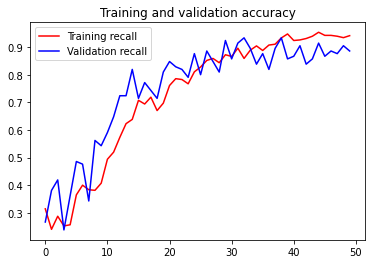

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training recall')
plt.plot(epochs, val_acc, 'b', label='Validation recall')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()